# SpecArgument Observe

## Configs

In [1]:
AUDIO_PATH: str = "../demo_data/audios/common_voice_zh-TW_18683232.mp3"
JSONL_DATA_PATH: str = "../demo_data/demo_jsonl_dataset.jsonl"
SAMPLING_RATE: int = 16000
LANG: str = "zh-TW"
TRANSCRIPT_COL: str = "text"
AUDIO_COL: str = "audio"
DURATION_COL: str = "input_length"

## Imports

In [2]:
import os
import librosa
import IPython
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
from torchaudio.utils import download_asset
from transformers import WhisperProcessor
from datasets import set_caching_enabled
from typing import List, Dict
from torch import Tensor

from audiopipeline.data.argumentation import spec_argument
from audiopipeline.data import hf_audio_dataset
from audiopipeline.data.hf_audio_dataset import HfAudioDataset
from audiopipeline.data.collator import HfDataCollatorSpeechSeq2SeqWithPadding

## Previews

In [3]:
IPython.display.Audio(AUDIO_PATH)

## Common Functions

In [4]:
def visualization_spectrogram(mel_spectrogram, title="spec"):
    # Show mel-spectrogram using librosa's specshow.
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(librosa.power_to_db(mel_spectrogram[0, :, :], ref=np.max), y_axis='mel', fmax=8000, x_axis='time')
    # plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

## Log-Mel Spec-Argumentation Visualization

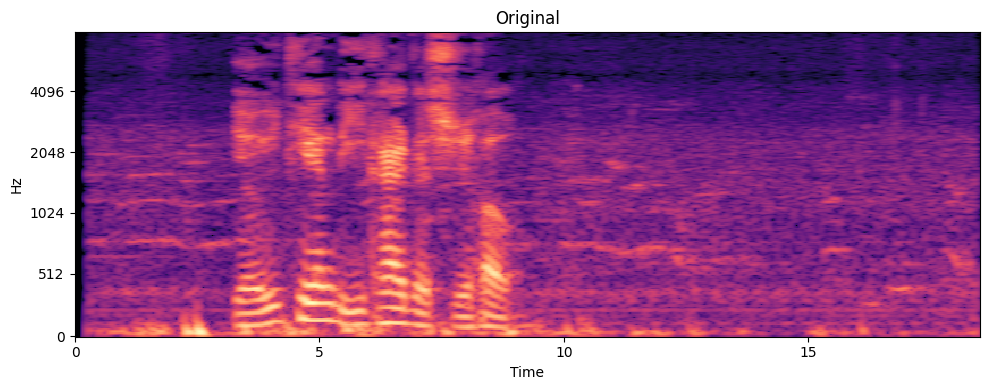

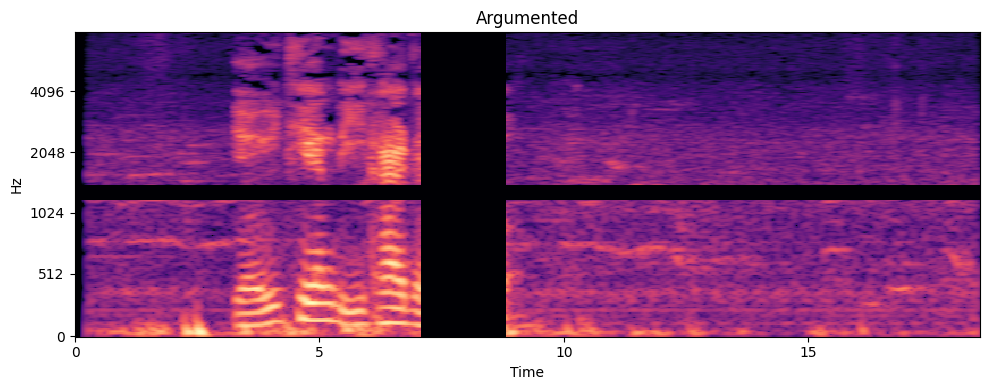

In [6]:
audio, sampling_rate = librosa.load(AUDIO_PATH)
mel_spectrogram = librosa.feature.melspectrogram(
    y=audio, sr=sampling_rate, n_mels=256, hop_length=128, fmax=8000
)
shape = mel_spectrogram.shape
channels = shape[0]
time = shape[1]

original_spec = np.reshape(mel_spectrogram, (-1, shape[0], shape[1]))
argumented_spec = np.array(spec_argument(
    #original_spec.tolist(),
    mel_spectrogram.tolist(),
    freq_before_time_axis=False,
    freq_masking_prob=0.9, 
    freq_max_masking_ratio=0.1,
    time_masking_prob=0.9,
    time_max_masking_ratio=0.1
))


visualization_spectrogram(original_spec, "Original")
visualization_spectrogram(argumented_spec, "Argumented")

## Log-Mel Spec-Argumentation Visualization with `audiopipeline.data.collator`

In [11]:
set_caching_enabled(False)
 
processor: WhisperProcessor = WhisperProcessor.from_pretrained(
    "openai/whisper-small", language="mandarin", task="transcribe"
)
dataset: HfAudioDataset = HfAudioDataset(
    JSONL_DATA_PATH, JSONL_DATA_PATH, JSONL_DATA_PATH, processor, 
    sampling_rate=16000, 
    lang=LANG, 
    audio_path_col="path", text_col=TRANSCRIPT_COL, 
    audio_col=AUDIO_COL, duration_col=DURATION_COL,
    max_duration=3, 
    waveform_argument_splits=[],
    num_proc=1
)
 
collator_with_spec_argument: HfDataCollatorSpeechSeq2SeqWithPadding = \
    HfDataCollatorSpeechSeq2SeqWithPadding(
        processor=processor, tokenizer=None, 
        model_input_col="input_features", model_label_col="labels", 
        spec_argument=True, 
        freq_masking_prob=1, freq_max_masking_ratio=0.1, 
        time_masking_prob=1, time_max_masking_ratio=0.1
    )
collator_without_spec_argument: HfDataCollatorSpeechSeq2SeqWithPadding = \
    HfDataCollatorSpeechSeq2SeqWithPadding(
        processor=processor, tokenizer=None, 
        model_input_col="input_features", model_label_col="labels", 
        spec_argument=False, 
        freq_masking_prob=1, freq_max_masking_ratio=0.1, 
        time_masking_prob=1, time_max_masking_ratio=0.1
    )
 
final_train_data: List[Dict] = [
    x for x in dataset.get_final_datasets()["train"]
]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Static dataset will not be kept in memory
Constructing static dataset
Running dataset dict JSONL loader
Running dataset audio loader
Running dataset audio loader
Running dataset audio loader
Building final train dataset
Running dataset raw text pre-processing
Converting zh-TW to simplified Chinese


Map:   0%|          | 0/8 [00:00<?, ? examples/s]

Running dataset HuggingFace processor


Map:   0%|          | 0/8 [00:00<?, ? examples/s]

Running dataset filter


Filter:   0%|          | 0/8 [00:00<?, ? examples/s]

Building final validation dataset
Running dataset raw text pre-processing
Converting zh-TW to simplified Chinese


Map:   0%|          | 0/8 [00:00<?, ? examples/s]

Running dataset HuggingFace processor


Map:   0%|          | 0/8 [00:00<?, ? examples/s]

Running dataset filter


Filter:   0%|          | 0/8 [00:00<?, ? examples/s]

Building final test dataset
Running dataset raw text pre-processing
Converting zh-TW to simplified Chinese


Map:   0%|          | 0/8 [00:00<?, ? examples/s]

Running dataset HuggingFace processor


Map:   0%|          | 0/8 [00:00<?, ? examples/s]

Running dataset filter


Filter:   0%|          | 0/8 [00:00<?, ? examples/s]

(1, 80, 3000)
(1, 80, 3000)


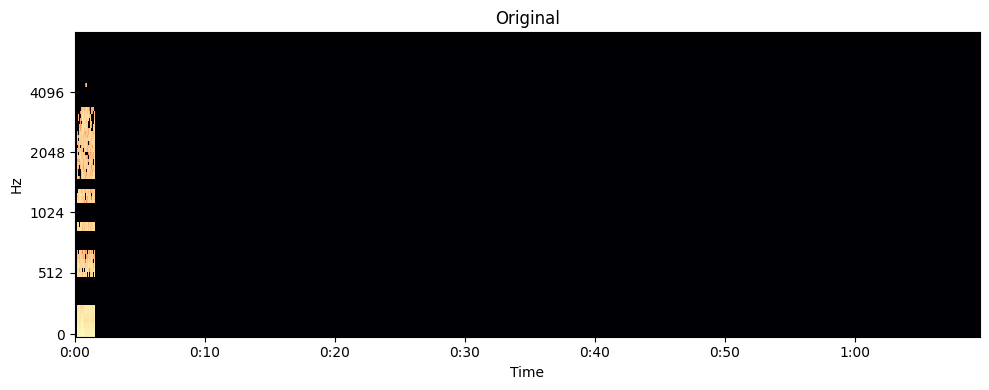

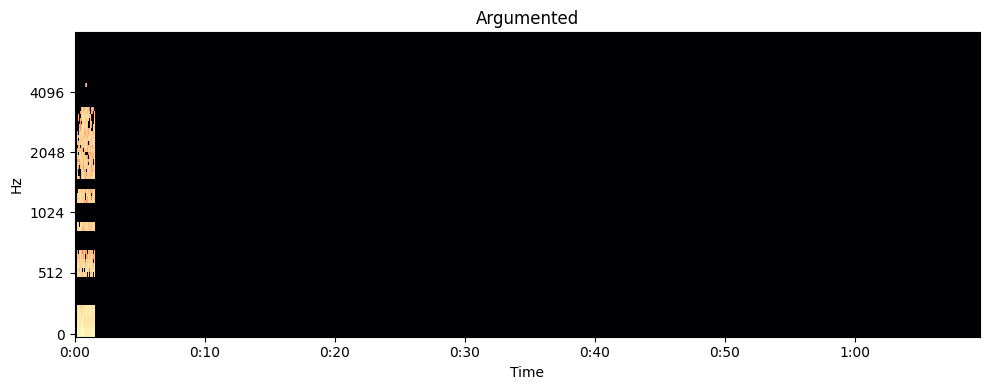

In [20]:
final_train_batch: List[Dict] = final_train_data[-2:-1]
train_inputs_with_spec_argument: Dict = \
    collator_with_spec_argument.spec_argumentation(final_train_batch)
train_input_without_spec_arguments: Dict = \
    collator_without_spec_argument.spec_argumentation(final_train_batch)

sample_with_spec_argument: Dict = train_inputs_with_spec_argument[0]
sample_without_spec_argument: Dict = [
    x for x in train_input_without_spec_arguments 
    if x[TRANSCRIPT_COL] == sample_with_spec_argument[TRANSCRIPT_COL]
][0]

spec_with_argument: np.ndarray = np.array(sample_with_spec_argument["input_features"])
spec_without_argument: np.ndarray = np.array(sample_without_spec_argument["input_features"])
print(spec_with_argument.shape)
print(spec_without_argument.shape)

visualization_spectrogram(spec_with_argument, "Original")
visualization_spectrogram(np.array(final_train_batch[0]["input_features"]), "Argumented")